In [21]:
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')

import torch
import torch.nn.functional as F
import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import HMC
from pyro.infer import EmpiricalMarginal
from tqdm import tqdm
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class _PlotColor(object):
    """Enum of colors """
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
PlotColor = _PlotColor()

#### Coin Flip Example

In [3]:

num_trials = torch.tensor([0,1, 2, 3, 4, 5, 8, 15, 50, 500, 1000, 2000])
coin_flip_prior = pyro.distributions.Bernoulli(probs=torch.ones(num_trials[-1]) *0.5)
coin_flip_data = pyro.sample('coin_flip', coin_flip_prior)

# pad the left side with 0 for the 0th flip
coin_flip_sequence = F.pad(coin_flip_data, (1, 0), value=0)
# cumulative counts of heads
coin_flip_scores = torch.cumsum(coin_flip_sequence, 0)[num_trials]


In [4]:
rv_observed_heads = pyro.distributions.Beta(
    concentration1=torch.tensor(1 + coin_flip_scores).double(),
    concentration0=torch.tensor(1 + num_trials - coin_flip_scores).double())


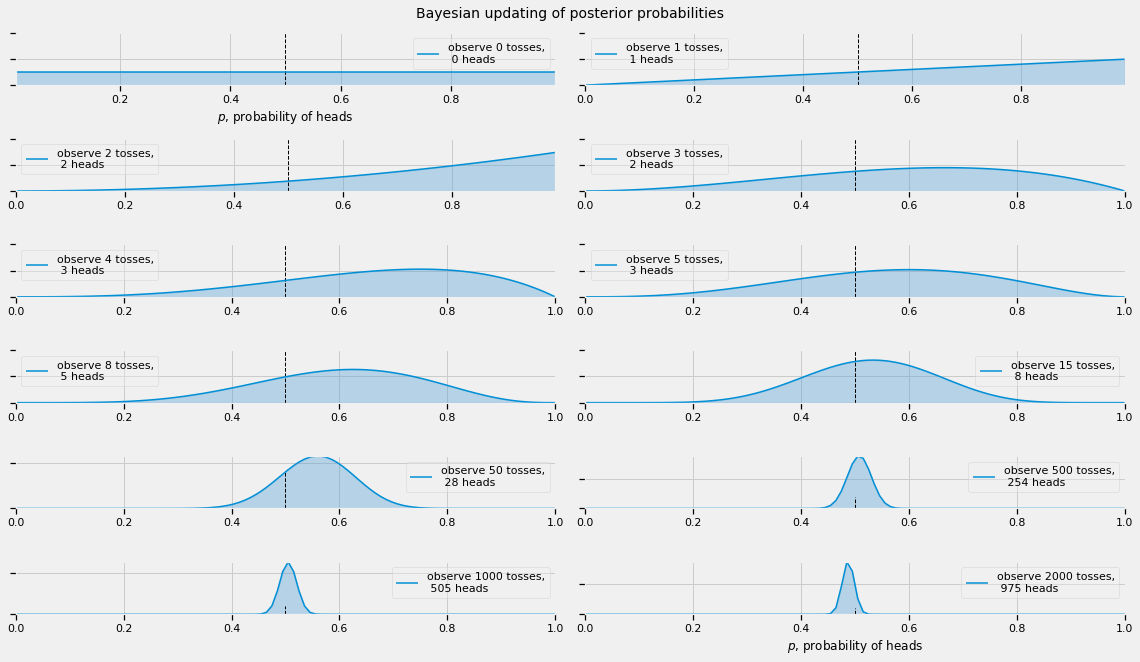

In [5]:
# For the already prepared, I'm using Binomial's conj. prior.
probs_of_heads = torch.linspace(start=0., end=1., steps=100)
observed_probs_heads = torch.exp(rv_observed_heads.log_prob(probs_of_heads[:, None]))
plt.figure(figsize=(16, 9))
for i in range(len(num_trials)):
    sx = plt.subplot(len(num_trials)/2, 2, i+1)
    plt.xlabel("$p$, probability of heads") \
    if i in [0, len(num_trials)-1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(probs_of_heads, observed_probs_heads[:, i], 
             label="observe %d tosses,\n %d heads" % (num_trials[i], coin_flip_scores[i]))
    plt.fill_between(probs_of_heads, 0, observed_probs_heads[:, i], 
                     color='#5DA5DA', alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()

### 1.4 Text message data

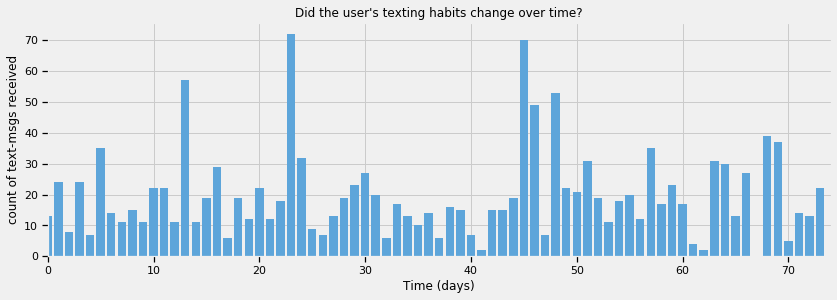

In [6]:
count_data = torch.tensor([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=torch.float32)
n_count_data = len(count_data)
days = torch.range(start=0, end=n_count_data -1 )

# Visualizing the Results
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy().squeeze(), count_data.numpy().squeeze(), color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

We model the text msg count as Poission distribution (defined by $\lambda$) , with a switchover point.

Each $\lambda$ is parameterized by $\alpha$
$$\lambda = 
\begin{cases} \lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

$$
\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha_1 ) \\
&\lambda_2 \sim \text{Exp}( \alpha_2 )
\end{align}
$$

In [11]:
def model(data):
    alpha = (1. / data.mean())
    lambda1 = pyro.sample("lambda1", dist.Exponential(rate=alpha))
    lambda2 = pyro.sample("lambda2", dist.Exponential(rate=alpha))

    tau = pyro.sample("tau", dist.Uniform(0, 1))
    lambda1_size = (tau * data.size(0) + 1).long()
    lambda2_size = data.size(0) - lambda1_size
    lambda_ = torch.cat([lambda1.expand((lambda1_size,)), lambda2.expand((lambda2_size,))])
    
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Poisson(lambda_), obs=data)
hmc_kernel = HMC(model, jit_compile=True, step_size=0.0855, num_steps=4)
nuts_kernel = NUTS(model, jit_compile=True, max_tree_depth=2, adapt_step_size=True,)
mcmc = MCMC(nuts_kernel, num_samples=10000, warmup_steps=5000, num_chains=1)
mcmc.run(count_data)

lambda_1_samples = mcmc.get_samples()["lambda1"]
lambda_2_samples = mcmc.get_samples()["lambda2"]
tau_samples = mcmc.get_samples()["tau"]



Sample: 100%|██████████| 15000/15000 [00:42, 352.57it/s, step size=3.72e-01, acc. prob=0.781]


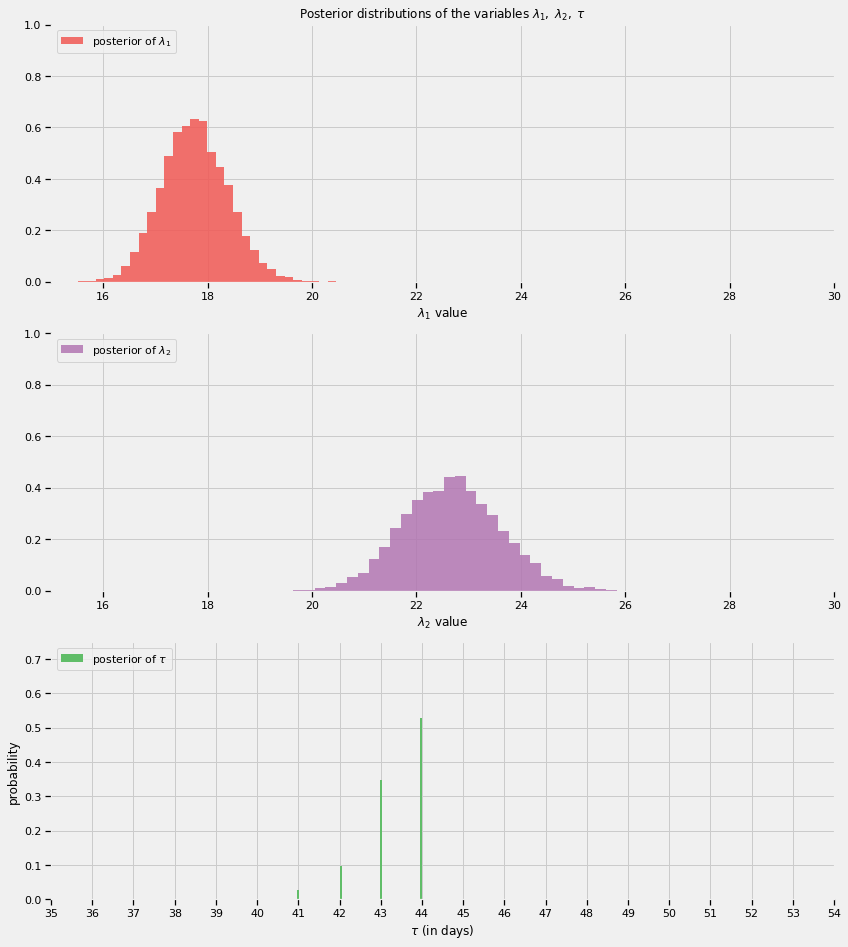

In [12]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$", color=PlotColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=PlotColor[6], density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist((tau_samples * n_count_data).int(), bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color=PlotColor[2], weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

In [45]:
num_samples = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in tqdm(range(n_count_data)):
    indexes = torch.where(day < (tau_samples * n_count_data).int())[0].long() 
    inverse_indexes = torch.where(day >= (tau_samples * n_count_data).int())[0].long() 
    inverse_index[indexes] = 0
    inverse_index = inverse_index.bool()
    expected_texts_per_day[day] = (lambda_1_samples.index_select(0, indexes).sum() + lambda_2_samples.index_select(0, inverse_indexes).sum()) / num_samples


100%|██████████| 74/74 [00:00<00:00, 6242.53it/s]


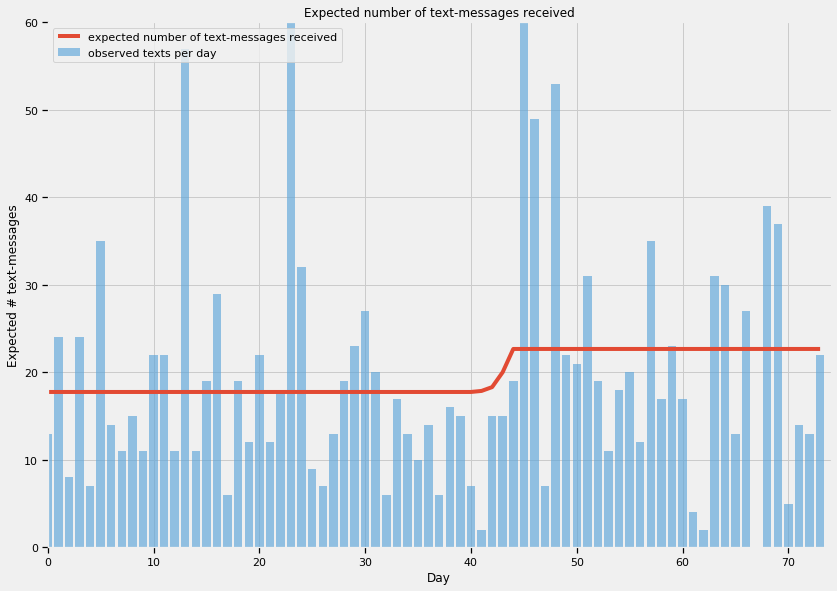

In [46]:


plt.figure(figsize=(12.5, 9))
plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#5DA5DA", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

In [42]:
lambda_1_samples

tensor([18.5231, 18.8324, 18.6827,  ..., 18.2884, 18.3793, 18.3639])

### Exercises

Using lambda_1_samples and lambda_2_samples, what is the mean of the posterior distributions of 𝜆1 and 𝜆2?

In [47]:
lambda_1_samples.mean(), lambda_2_samples.mean()

(tensor(17.7559), tensor(22.6729))

What is the expected percentage increase in text-message rates? hint: compute the mean of lambda_1_samples/lambda_2_samples. Note that this quantity is very different from lambda_1_samples.mean()/lambda_2_samples.mean()

Text(0.5, 0, '% increase')

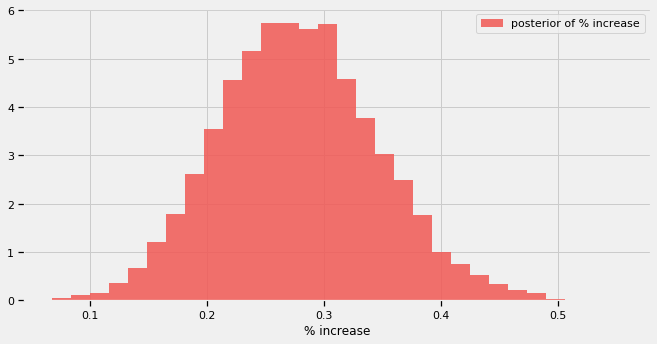

In [52]:
percentage_increase_distribution = (lambda_2_samples - lambda_1_samples) / lambda_1_samples

plt.figure(figsize=(10, 5))

plt.hist(percentage_increase_distribution, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of % increase", color=PlotColor[0], density=True)
plt.legend(loc="upper right")

plt.xlabel("% increase")